
# 🧠 Robust Multimodal Emotion & Strategy Classifier (ResNet + Audio + Text)

This notebook includes:
- Balanced CSV loading  
- Safe image/audio reading (graceful failure logging)  
- Debug mode with `num_workers=0`  
- Full train/val loop  
- Save and reload trained model


In [5]:

import os, random, json, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Config
CSV_PATH = 'MESC_cleaned_balanced.csv'
FRAME_COLS = [f'Frame_{i}' for i in range(1,13)]
TEXT_COL, EMOTION_COL, STRATEGY_COL = 'Utterance','Emotion','Strategy'
SAMPLE_RATE, N_MELS = 16000, 128
BATCH_SIZE, EPOCHS, LR = 4, 3, 2e-4
NUM_WORKERS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [6]:

# Load CSV and encode
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL,EMOTION_COL,STRATEGY_COL,'Audio']+FRAME_COLS)
le_e, le_s = LabelEncoder().fit(df[EMOTION_COL]), LabelEncoder().fit(df[STRATEGY_COL])
df['emotion_id'], df['strategy_id'] = le_e.transform(df[EMOTION_COL]), le_s.transform(df[STRATEGY_COL])
num_emotions, num_strategies = len(le_e.classes_), len(le_s.classes_)
print(num_emotions,"emotions", num_strategies,"strategies")
train_df, val_df = train_test_split(df,test_size=0.15,random_state=42,stratify=df['emotion_id'])


6 emotions 7 strategies


In [7]:

# Safe loaders
def safe_img(path):
    try:
        path=os.path.normpath(path)
        return Image.open(path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Image failed: {path} -> {e}")
import soundfile as sf
import torchaudio.functional as F

def safe_audio(path):
    try:
        path = os.path.normpath(path)
        # Read using libsndfile backend
        wav, sr = sf.read(path, dtype='float32', always_2d=False)
        wav = torch.tensor(wav, dtype=torch.float32)
        if wav.ndim > 1:  # stereo → mono
            wav = wav.mean(dim=-1)
        wav = wav.unsqueeze(0)  # shape [1, T]
        if sr != SAMPLE_RATE:
            wav = F.resample(wav, sr, SAMPLE_RATE)
        return wav
    except Exception as e:
        raise RuntimeError(f"Audio failed: {path} -> {e}")



In [8]:

img_tf=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
melspec=torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,n_mels=N_MELS)
amp2db=torchaudio.transforms.AmplitudeToDB()

class ClipDS(Dataset):
    def __init__(self,df):self.df=df.reset_index(drop=True)
    def __len__(self):return len(self.df)
    def __getitem__(self,i):
        try:
            row=self.df.loc[i]
            fr=[img_tf(safe_img(row[c])) for c in FRAME_COLS]
            wav=safe_audio(row['Audio'])
            mel=amp2db(melspec(wav)).squeeze(0).mean(-1)
            return {'utt':row[TEXT_COL],'frames_12':torch.stack(fr),
                    'audio_feat':mel,'emo':int(row['emotion_id']),'strat':int(row['strategy_id'])}
        except Exception as e:raise RuntimeError(f"Idx {i}: {e}")


C:\Users\Ezaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:

def tok(texts,max_len=64):
    arr=[[ord(c)%10000 for c in t][:max_len] for t in texts]
    L=max(len(a) for a in arr)
    x=torch.zeros(len(arr),L).long()
    for i,a in enumerate(arr):x[i,:len(a)]=torch.tensor(a)
    return x,torch.ones_like(x)
def collate(b):
    ids,att=tok([x['utt'] for x in b])
    fr=torch.stack([x['frames_12'] for x in b])
    au=torch.stack([x['audio_feat'] for x in b])
    e=torch.tensor([x['emo'] for x in b]);s=torch.tensor([x['strat'] for x in b])
    return {'input_ids':ids,'att':att,'frames':fr,'audio':au,'emo':e,'strat':s}

train_dl=DataLoader(ClipDS(train_df),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate)
val_dl=DataLoader(ClipDS(val_df),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate)
print("Train:",len(train_dl.dataset))


Train: 208


In [10]:
from torchvision import models
import torch
import torch.nn as nn

# --- Vision backbone: MobileNetV3-Small for 1-channel input, outputs 576-d ---
def mobilenet_gray():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # Replace first 3->C conv with 1->C conv and port averaged weights
    first = m.features[0][0]  # Conv2d inside ConvBNActivation
    w = first.weight.mean(1, keepdim=True).clone()  # [C,1,3,3]
    m.features[0][0] = nn.Conv2d(
        in_channels=1,
        out_channels=first.out_channels,
        kernel_size=first.kernel_size,
        stride=first.stride,
        padding=first.padding,
        bias=False,
    )
    m.features[0][0].weight.data = w

    # Make it a feature extractor (global pooled 576-d, classifier removed)
    m.classifier = nn.Identity()
    return m, 576

# --- Text encoder (lighter: same hidden size, fewer heads/layers) ---
class TxtEnc(nn.Module):
    def __init__(self, h=512):
        super().__init__()
        self.emb = nn.Embedding(10000, h)
        e = nn.TransformerEncoderLayer(h, 4, batch_first=True)  # heads=4 (was 8)
        self.enc = nn.TransformerEncoder(e, 1)                  # layers=1 (was 2)

    def forward(self, ids, att):
        x = self.emb(ids)
        return self.enc(x), x[:, 0, :]

# --- Net (process unchanged) ---
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Vision
        self.v, v_dim = mobilenet_gray()        # v_dim = 576
        self.vp = nn.Linear(v_dim, 512)         # project to 512

        # Audio
        self.ap = nn.Linear(N_MELS, 512)

        # Text
        self.t = TxtEnc()

        # Cross-attention (keep same process)
        self.q  = nn.Linear(512, 512)
        self.k  = nn.Linear(512, 512)
        self.vv = nn.Linear(512, 512)
        self.att = nn.MultiheadAttention(512, 8, batch_first=True)

        # Heads
        self.he = nn.Linear(512, num_emotions)
        self.hs = nn.Linear(512, num_strategies)

        # Optional: freeze backbone to reduce training compute
        # for p in self.v.parameters():
        #     p.requires_grad = False

    def forward(self, fr, au, t):
        B = fr.size(0)

        # Vision → encode 12 frames, then average (unchanged)
        v = self.v(fr.view(B * 12, 1, 128, 128))   # [B*12, 576]
        v = v.view(B, 12, -1).mean(1)              # [B, 576]
        v = self.vp(v)                              # [B, 512]

        # Audio → project
        a = self.ap(au)                             # [B, 512]

        # Fuse A+V (unchanged)
        av = (v + a) / 2
        av = av.unsqueeze(1)                        # [B, 1, 512]

        # Text encoding (unchanged interface)
        seq, cls = self.t(t['input_ids'], t['att']) # [B, T, 512]

        # Cross-attention (unchanged)
        q, k, vv = self.q(seq), self.k(av), self.vv(av)
        o, _ = self.att(q, k, vv)                   # [B, T, 512]
        fz = o[:, 0, :]                             # first token

        # Predict
        emo = self.he(fz)
        strat = self.hs(fz)
        return emo, strat



model = Net().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()


In [18]:
from tqdm import tqdm

def run_epoch(model, dl, train=True):
    model.train(train)
    total_emo_loss, total_str_loss = 0.0, 0.0
    correct_emo, correct_str = 0, 0
    total_samples = 0

    phase = "Train" if train else "Val"
    pbar = tqdm(dl, desc=f"{phase} epoch", leave=False)

    for batch in pbar:
        # ---------------- Inputs ----------------
        frames = batch['frames'].to(device)
        audio = batch['audio'].to(device)
        emo_gt = batch['emo'].to(device)
        strat_gt = batch['strat'].to(device)
        text = {'input_ids': batch['input_ids'].to(device),
                'att': batch['att'].to(device)}

        # ---------------- Forward / Backward ----------------
        with torch.set_grad_enabled(train):
            emo_pred, strat_pred = model(frames, audio, text)
            loss_emo = ce(emo_pred, emo_gt)
            loss_str = ce(strat_pred, strat_gt)
            total_loss = loss_emo + loss_str

            if train:
                opt.zero_grad()
                total_loss.backward()
                opt.step()

        # ---------------- Metrics ----------------
        bs = frames.size(0)
        total_samples += bs
        total_emo_loss += loss_emo.item() * bs
        total_str_loss += loss_str.item() * bs
        correct_emo += (emo_pred.argmax(1) == emo_gt).sum().item()
        correct_str += (strat_pred.argmax(1) == strat_gt).sum().item()

        # live display
        pbar.set_postfix({
            "EmoLoss": f"{loss_emo.item():.3f}",
            "StrLoss": f"{loss_str.item():.3f}"
        })

    avg_emo_loss = total_emo_loss / total_samples
    avg_str_loss = total_str_loss / total_samples
    emo_acc = correct_emo / total_samples
    strat_acc = correct_str / total_samples

    return {
        "emo_loss": avg_emo_loss,
        "emo_acc": emo_acc,
        "str_loss": avg_str_loss,
        "str_acc": strat_acc
    }

# ---------------- Training Loop ----------------
history = []
for ep in range(1, 20 + 1):
    print(f"\n🟩 Epoch {ep}/{EPOCHS}")
    train_metrics = run_epoch(model, train_dl, True)
    val_metrics   = run_epoch(model, val_dl, False)

    print(f"📊 Train — "
          f"Emotion Loss: {train_metrics['emo_loss']:.4f}, "
          f"Acc: {train_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {train_metrics['str_loss']:.4f}, "
          f"Acc: {train_metrics['str_acc']*100:.2f}%")

    print(f"🧪 Val   — "
          f"Emotion Loss: {val_metrics['emo_loss']:.4f}, "
          f"Acc: {val_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {val_metrics['str_loss']:.4f}, "
          f"Acc: {val_metrics['str_acc']*100:.2f}%")

    history.append((train_metrics, val_metrics))

torch.save(model.state_dict(), "robust_avt_model.pth")
print("\n✅ Model saved as robust_avt_model.pth")



🟩 Epoch 1/3


📊 Train — Emotion Loss: 1.8858, Acc: 37.50% | Strategy Loss: 2.8369, Acc: 25.96%
🧪 Val   — Emotion Loss: 1.3475, Acc: 27.03% | Strategy Loss: 1.9409, Acc: 16.22%

🟩 Epoch 2/3


📊 Train — Emotion Loss: 1.3651, Acc: 45.67% | Strategy Loss: 1.5587, Acc: 39.90%
🧪 Val   — Emotion Loss: 1.1449, Acc: 62.16% | Strategy Loss: 1.8091, Acc: 21.62%

🟩 Epoch 3/3


📊 Train — Emotion Loss: 1.0701, Acc: 57.21% | Strategy Loss: 1.2848, Acc: 50.96%
🧪 Val   — Emotion Loss: 1.4126, Acc: 51.35% | Strategy Loss: 1.9557, Acc: 40.54%

🟩 Epoch 4/3


📊 Train — Emotion Loss: 0.8525, Acc: 69.23% | Strategy Loss: 1.1067, Acc: 61.54%
🧪 Val   — Emotion Loss: 1.4016, Acc: 48.65% | Strategy Loss: 2.2080, Acc: 43.24%

🟩 Epoch 5/3


📊 Train — Emotion Loss: 0.6806, Acc: 74.04% | Strategy Loss: 0.9504, Acc: 58.65%
🧪 Val   — Emotion Loss: 1.8543, Acc: 51.35% | Strategy Loss: 1.9469, Acc: 16.22%

🟩 Epoch 6/3


📊 Train — Emotion Loss: 0.6134, Acc: 77.40% | Strategy Loss: 0.8793, Acc: 67.31%
🧪 Val   — Emotion Loss: 2.5708, Acc: 27.03% | Strategy Loss: 3.2969, Acc: 13.51%

🟩 Epoch 7/3


📊 Train — Emotion Loss: 0.7418, Acc: 72.12% | Strategy Loss: 0.8442, Acc: 69.71%
🧪 Val   — Emotion Loss: 4.5602, Acc: 37.84% | Strategy Loss: 5.3430, Acc: 13.51%

🟩 Epoch 8/3


📊 Train — Emotion Loss: 0.7009, Acc: 72.60% | Strategy Loss: 0.8386, Acc: 69.23%
🧪 Val   — Emotion Loss: 2.1500, Acc: 37.84% | Strategy Loss: 3.3447, Acc: 18.92%

🟩 Epoch 9/3


📊 Train — Emotion Loss: 0.5428, Acc: 79.33% | Strategy Loss: 0.6124, Acc: 75.96%
🧪 Val   — Emotion Loss: 3.6088, Acc: 18.92% | Strategy Loss: 4.3138, Acc: 21.62%

🟩 Epoch 10/3


📊 Train — Emotion Loss: 0.4083, Acc: 84.62% | Strategy Loss: 0.5556, Acc: 82.21%
🧪 Val   — Emotion Loss: 2.3558, Acc: 43.24% | Strategy Loss: 2.5924, Acc: 13.51%

🟩 Epoch 11/3


📊 Train — Emotion Loss: 0.3895, Acc: 87.50% | Strategy Loss: 0.3665, Acc: 89.90%
🧪 Val   — Emotion Loss: 1.7604, Acc: 29.73% | Strategy Loss: 2.2694, Acc: 24.32%

🟩 Epoch 12/3


📊 Train — Emotion Loss: 0.4278, Acc: 85.10% | Strategy Loss: 0.5353, Acc: 77.40%
🧪 Val   — Emotion Loss: 4.8126, Acc: 35.14% | Strategy Loss: 2.8385, Acc: 40.54%

🟩 Epoch 13/3


📊 Train — Emotion Loss: 0.4133, Acc: 86.54% | Strategy Loss: 0.5322, Acc: 84.13%
🧪 Val   — Emotion Loss: 0.8695, Acc: 75.68% | Strategy Loss: 1.5239, Acc: 51.35%

🟩 Epoch 14/3


📊 Train — Emotion Loss: 0.3665, Acc: 87.02% | Strategy Loss: 0.5160, Acc: 84.13%
🧪 Val   — Emotion Loss: 0.5628, Acc: 83.78% | Strategy Loss: 0.5960, Acc: 78.38%

🟩 Epoch 15/3


📊 Train — Emotion Loss: 0.2483, Acc: 89.42% | Strategy Loss: 0.3821, Acc: 87.98%
🧪 Val   — Emotion Loss: 0.4726, Acc: 81.08% | Strategy Loss: 0.5465, Acc: 78.38%

🟩 Epoch 16/3


📊 Train — Emotion Loss: 0.1746, Acc: 93.27% | Strategy Loss: 0.2897, Acc: 88.94%
🧪 Val   — Emotion Loss: 0.5348, Acc: 81.08% | Strategy Loss: 0.5652, Acc: 75.68%

🟩 Epoch 17/3


📊 Train — Emotion Loss: 0.2146, Acc: 90.87% | Strategy Loss: 0.2015, Acc: 93.75%
🧪 Val   — Emotion Loss: 0.2123, Acc: 89.19% | Strategy Loss: 0.2250, Acc: 86.49%

🟩 Epoch 18/3


📊 Train — Emotion Loss: 0.1140, Acc: 96.15% | Strategy Loss: 0.1664, Acc: 95.67%
🧪 Val   — Emotion Loss: 0.1329, Acc: 97.30% | Strategy Loss: 0.2667, Acc: 86.49%

🟩 Epoch 19/3


📊 Train — Emotion Loss: 0.2828, Acc: 89.42% | Strategy Loss: 0.2883, Acc: 91.35%
🧪 Val   — Emotion Loss: 0.8962, Acc: 75.68% | Strategy Loss: 1.0276, Acc: 81.08%

🟩 Epoch 20/3


📊 Train — Emotion Loss: 0.2195, Acc: 93.27% | Strategy Loss: 0.2771, Acc: 90.38%
🧪 Val   — Emotion Loss: 0.0485, Acc: 97.30% | Strategy Loss: 0.4556, Acc: 83.78%

✅ Model saved as robust_avt_model.pth


In [11]:
from PIL import Image
import torch

def predict_sample(model, frame_paths, audio_path, utterance, le_emotion, le_strategy):
    """
    frame_paths: list of 12 grayscale 128x128 image paths
    audio_path: path to WAV file
    utterance: text (string)
    le_emotion, le_strategy: trained label encoders
    """

    # --- Preprocess frames ---
    frames = [img_tf(safe_img(p)) for p in frame_paths]
    frames = torch.stack(frames).unsqueeze(0).to(device)  # [1,12,1,128,128]

    # --- Preprocess audio ---
    wav = safe_audio(audio_path)
    mel = amp2db(melspec(wav)).squeeze(0).mean(-1)
    mel = mel.unsqueeze(0).to(device)  # [1, N_MELS]

    # --- Text tokens ---
    ids, att = tok([utterance])
    text = {'input_ids': ids.to(device), 'att': att.to(device)}

    # --- Forward pass ---
    with torch.no_grad():
        emo_pred, strat_pred = model(frames, mel, text)
        emo_id = emo_pred.argmax(1).item()
        strat_id = strat_pred.argmax(1).item()

    # --- Decode labels ---
    emotion = le_emotion.inverse_transform([emo_id])[0]
    strategy = le_strategy.inverse_transform([strat_id])[0]

    print(f"🧩 Predicted Emotion:  {emotion}")
    print(f"🗣️  Predicted Strategy: {strategy}")

    return emotion, strategy


In [12]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def show_prediction_sample(model, df, le_emotion, le_strategy):
    """
    Randomly picks one row from df, visualizes 12 frames, plays audio,
    shows utterance text, and prints predicted + true labels.
    """

    row = df.sample(1).iloc[0]
    frame_paths = [row[f] for f in FRAME_COLS]
    audio_path  = row['Audio']
    utterance   = row['Utterance']

    print("="*90)
    print(f"🎬 Utterance: {utterance}")
    print(f"🎧 Audio: {audio_path}")
    print("="*90)

    # Display frames
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, (ax, path) in enumerate(zip(axes.flatten(), frame_paths)):
        try:
            img = Image.open(path).convert("L")
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Frame {i+1}", fontsize=10)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Play audio
    print("🔊 Playing audio:")
    display(Audio(audio_path, autoplay=False))

    # Run prediction
    pred_emotion, pred_strategy = predict_sample(
        model,
        frame_paths=frame_paths,
        audio_path=audio_path,
        utterance=utterance,
        le_emotion=le_emotion,
        le_strategy=le_strategy
    )

    true_emotion  = row[EMOTION_COL]
    true_strategy = row[STRATEGY_COL]
    print("\n================= RESULT SUMMARY =================")
    print(f"🧩 Predicted Emotion:  {pred_emotion}")
    print(f"🗣️  Predicted Strategy: {pred_strategy}")
    print(f"🎯 True Emotion:        {true_emotion}")
    print(f"🎯 True Strategy:       {true_strategy}")
    print("===================================================")

    return row


🎬 Utterance: So this guy follows me into the stall and suddenly I was horny. Is hearing about this disgusting to you?
🎧 Audio: audio\Dialogue_ID-7_Season-1_Episode-1_00-12-12.871_00-12-26.293.wav


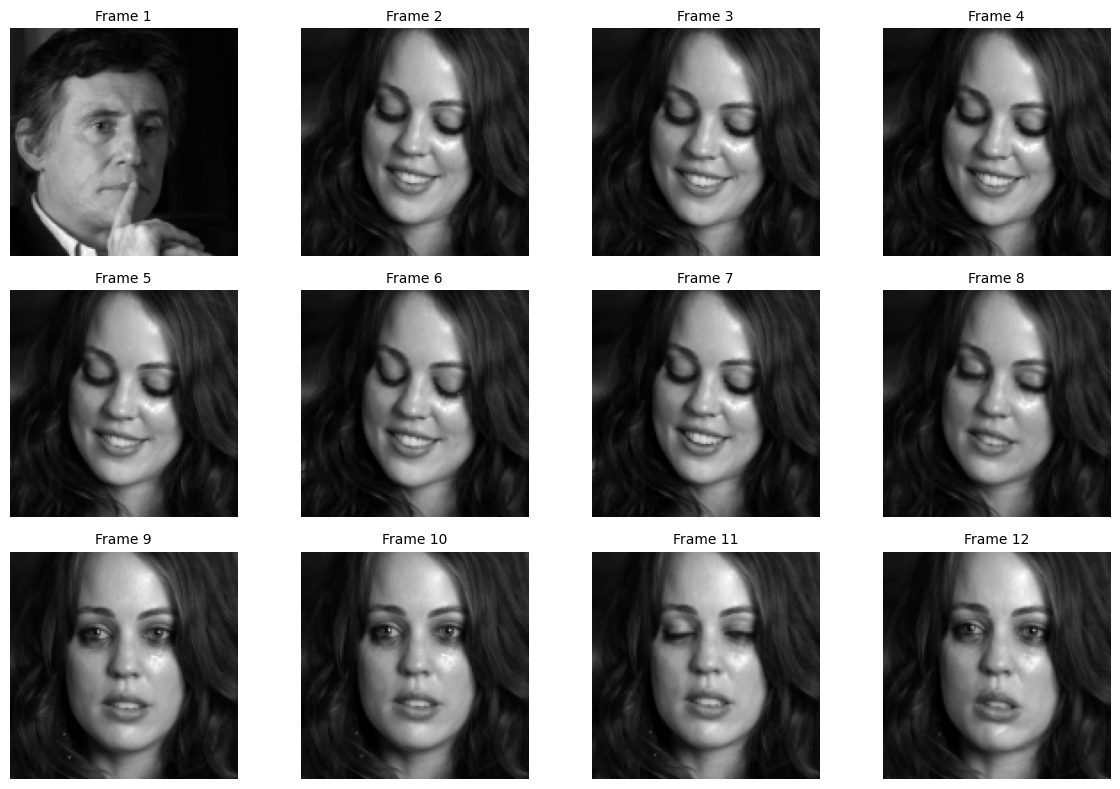

🔊 Playing audio:


🧩 Predicted Emotion:  joy
🗣️  Predicted Strategy: Approval

================= RESULT SUMMARY =================
🧩 Predicted Emotion:  joy
🗣️  Predicted Strategy: Approval
🎯 True Emotion:        joy
🎯 True Strategy:       Approval


Dialogue_ID                                                     7
split_group                                                     0
Season                                                          1
Episode                                                         1
StartTime                                            00:12:12,871
EndTime                                              00:12:26,293
Speaker                                                    Client
Utterance       So this guy follows me into the stall and sudd...
Emotion                                                       joy
Strategy                                                 Approval
Utterance_ID                                                    0
Frame_1         frames\Dialogue_ID-7_Season-1_Episode-1_f01_t0...
Frame_2         frames\Dialogue_ID-7_Season-1_Episode-1_f02_t0...
Frame_3         frames\Dialogue_ID-7_Season-1_Episode-1_f03_t0...
Frame_4         frames\Dialogue_ID-7_Season-1_Episode-1_f04_t0...
Frame_5   

In [14]:

# Load trained model and encoders first (if not already)
model_loaded = Net().to(device)
model_loaded.load_state_dict(torch.load("robust_avt_model.pth", map_location=device))
model_loaded.eval()

# Now predict on a random CSV row
show_prediction_sample(model_loaded, df, le_e, le_s)

